<a href="https://colab.research.google.com/github/Divyanshyadavofficial/RNN/blob/main/Sequences_and_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
assert sys.version_info>=(3,5)

IS_COLAB = "goggle.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import sklearn
assert sklearn.__version__>="0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__>="2.0"

if not tf.config.list_physical_devices('GPU'):
  print("No GPU was detected.")
  if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
  if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")
import numpy as np
import os
from pathlib import Path

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID)
os.makedirs(IMAGES_PATH,exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected.


### Basic RNN's

#### Generate the dataset

In [2]:
def generate_time_series(batch_size,n_steps):
  freq1,freq2,offset1,offset2 = np.random.rand(4,batch_size,1)
  time = np.linspace(0,1,n_steps)
  series = 0.5 * np.sin((time - offset1) * (freq1*10+10))
  series += 0.2 * np.sin((time-offset2)*(freq2*20+20))
  series += 0.1 *(np.random.rand(batch_size,n_steps)-0.5)
  return series[...,np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps=50
series = generate_time_series(10000,n_steps+1)
X_train,y_train = series[:7000,:n_steps],series[:7000,-1]
X_valid,y_valid = series[7000:9000,:n_steps],series[7000:9000,-1]
X_test,y_test = series[9000:,:n_steps],series[9000:,-1]

In [4]:
X_train.shape,y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure timeseries_plot


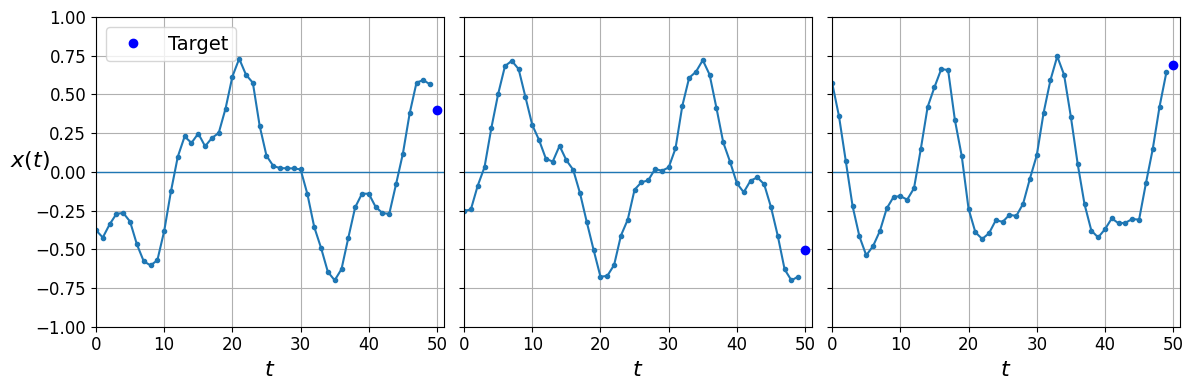

In [5]:
def plot_series(series,y=None,y_pred=None,x_label="$t$",y_label="$x(t)$",legend=True):
  plt.plot(series,".-")
  if y is not None:
    plt.plot(n_steps,y,"bo",label="Target")
  if y_pred is not None:
    plt.plot(n_steps,y_pred,"rx",markersize=10,label="Prediction")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0,0,100,linewidth=1)
  plt.axis([0,n_steps+1,-1,1])
  if legend and (y or y_pred):
    plt.legend(fontsize=14,loc="upper left")

fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(12,4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col,:,0],y_valid[col,0],
              y_label=("$x(t)$"if col==0 else None),
              legend=(col==0))
save_fig("timeseries_plot")
plt.show()

### Computing base lines

Naive predicictions(just predict the last observed value):



In [6]:
y_pred = X_valid[:, -1]
mse = tf.keras.losses.MeanSquaredError()
loss_value = mse(y_valid, y_pred).numpy()
print(loss_value)

0.020211365


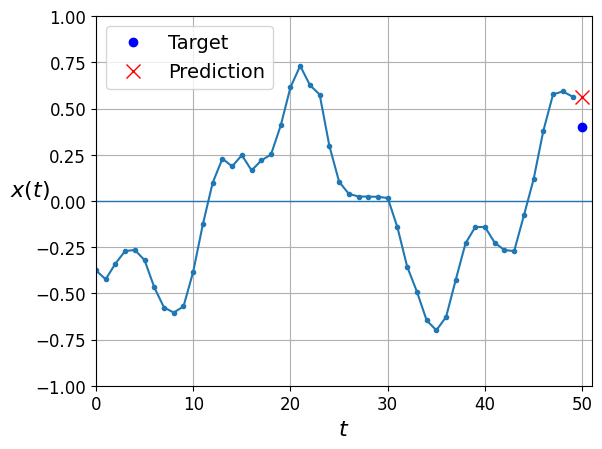

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Linear predictions

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2163 - val_loss: 0.0568
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460 - val_loss: 0.0301
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269 - val_loss: 0.0213
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - val_loss: 0.0168
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.0140
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

In [9]:
model.evaluate(X_valid,y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038


0.003866591490805149

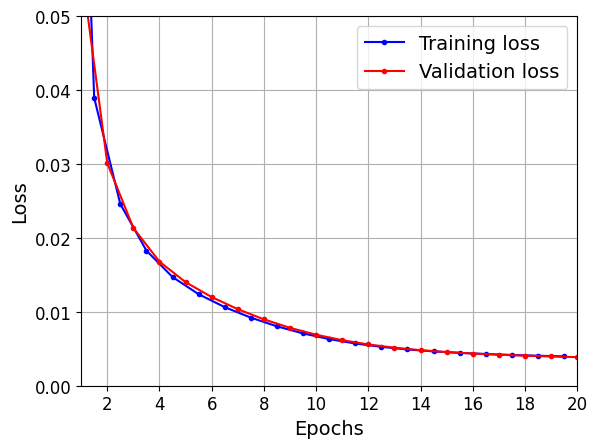

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


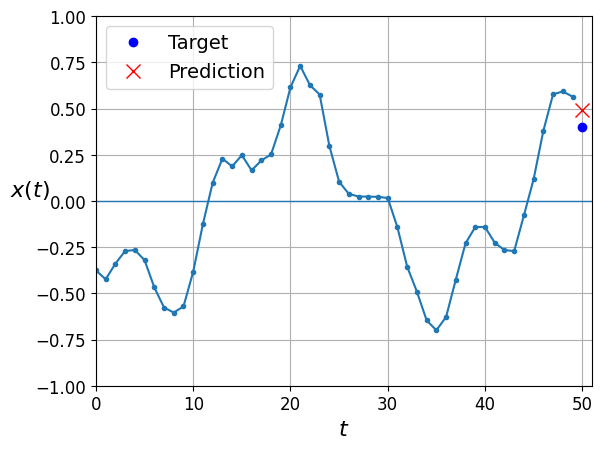

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

### Using simple Rnn

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1,input_shape=[None,1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse",optimizer=optimizer)
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.4126 - val_loss: 0.2617
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2082 - val_loss: 0.1239
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0973 - val_loss: 0.0491
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0378 - val_loss: 0.0193
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0164 - val_loss: 0.0122
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - los

In [13]:
model.evaluate(X_valid,y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110


0.010906727984547615

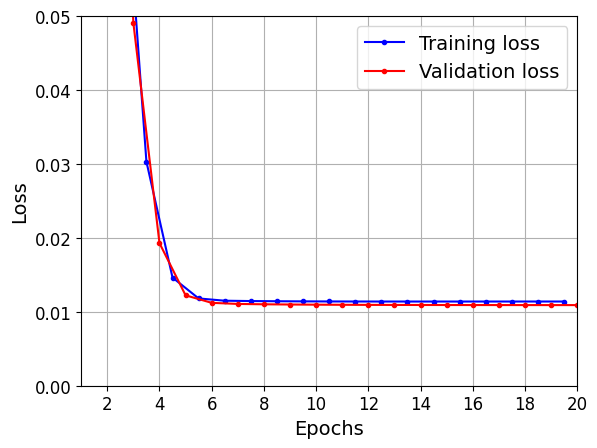

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


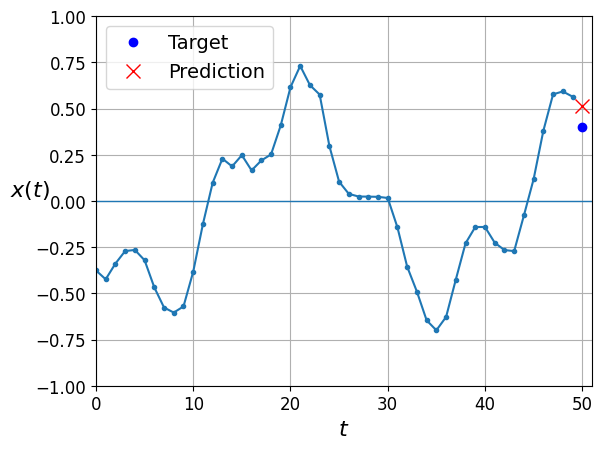

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train,y_train,epochs=20,
                    validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.1532 - val_loss: 0.0072
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0076 - val_loss: 0.0055
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train,y_train,epochs=20,
                    validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0361 - val_loss: 0.0059
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━

In [18]:
model.evaluate(X_valid,y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026


0.0027586519718170166

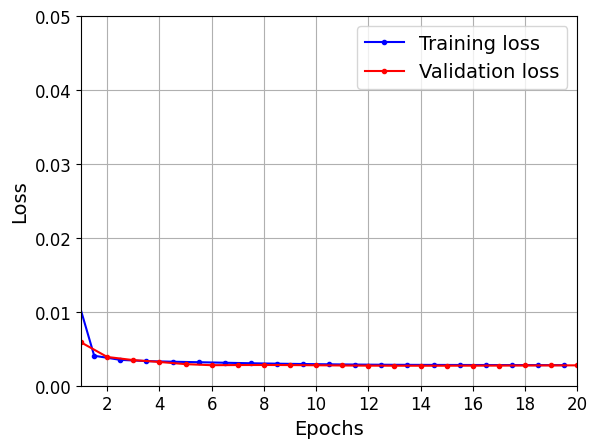

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


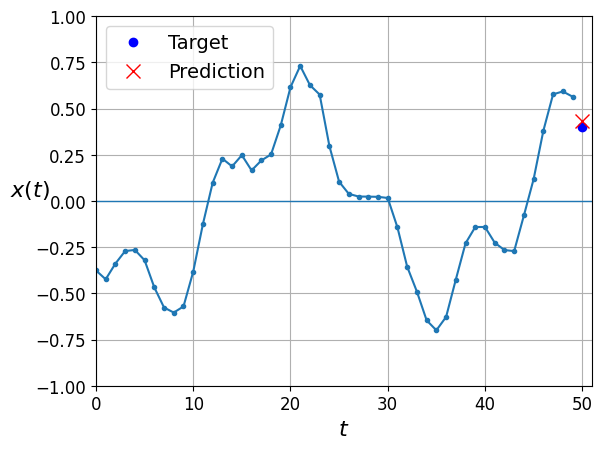

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [21]:
np.random.seed(43)

series = generate_time_series(1,n_steps+10)
X_new,Y_new = series[:,:n_steps],series[:,n_steps:]
X = X_new
for step_ahead in range(10):
  y_pred_one = model.predict(X[:,step_ahead:])[:,np.newaxis,:]
  X = np.concatenate([X,y_pred_one],axis=1)

Y_pred = X[:,n_steps:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [22]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


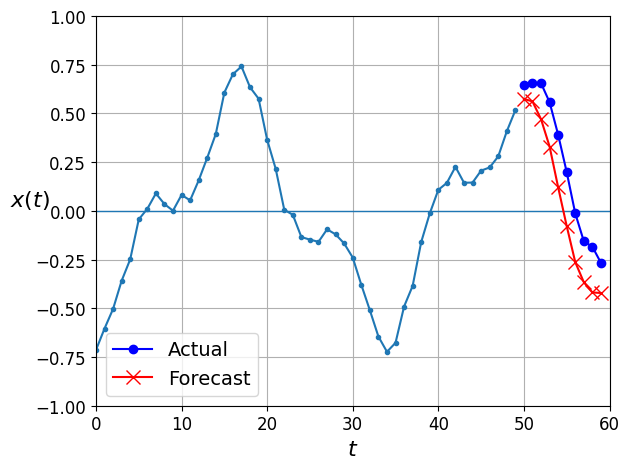

In [23]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values.We first need to regenerate the sequences with 9 more time steps

In [24]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000,n_steps+10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [25]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [26]:
Y_pred.shape

(2000, 10)

In [27]:
mse = tf.keras.losses.MeanSquaredError()
loss_value = mse(Y_valid, Y_pred).numpy()
print(loss_value)

0.027838148


Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [28]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
mse = tf.keras.losses.MeanSquaredError()
loss_value = mse(Y_naive_pred, Y_pred).numpy()
print(loss_value)

0.278346


In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1904 - val_loss: 0.0683
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0596 - val_loss: 0.0454
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0425 - val_loss: 0.0368
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0354 - val_loss: 0.0322
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0313 - val_loss: 0.0292
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0286 - val_loss: 0.0271
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0266 - val_loss: 0.0255
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0251 - val_loss: 0.0243
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0240 - val_loss: 0.0234
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0223 - val_loss: 0.0220
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Now let's create an RNN that predicts all 10 next values at once

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.1088 - val_loss: 0.0348
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0318 - val_loss: 0.0212
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0205 - val_loss: 0.0176
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0156 - val_loss: 0.0157
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0127 - val_loss: 0.0129
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0119 - val_loss: 0.0126
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0113 - val_loss: 0.0125
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0108 - val_loss: 0.0121
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0104 - val_loss: 0.0116
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0101 - val_loss: 0.0111
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━

In [31]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


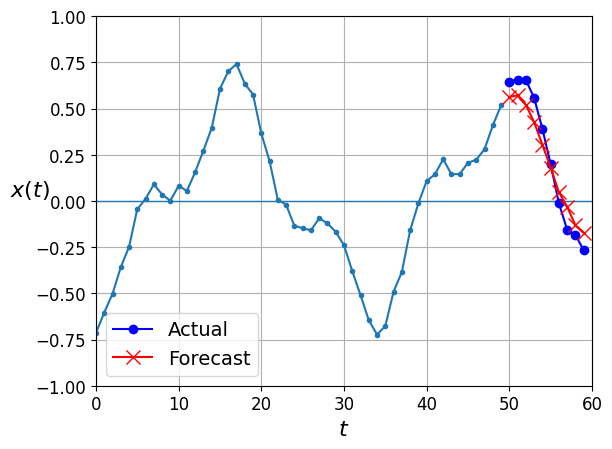

In [32]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [33]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000,n_steps+10)
X_train = series[:7000,:n_steps]
X_valid = series[7000:9000,:n_steps]
X_test = series[9000:,:n_steps]
Y = np.empty([10000,n_steps,10])
for step_ahead in range(1,10+1):
  Y[...,step_ahead-1] = series[...,step_ahead:step_ahead+n_steps,0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [34]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


mse = tf.keras.losses.MeanSquaredError()

def last_time_step_mse(Y_true, Y_pred):
    return mse(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - last_time_step_mse: 0.0582 - loss: 0.0662 - val_last_time_step_mse: 0.0241 - val_loss: 0.0364
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - last_time_step_mse: 0.0234 - loss: 0.0358 - val_last_time_step_mse: 0.0154 - val_loss: 0.0289
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - last_time_step_mse: 0.0164 - loss: 0.0297 - val_last_time_step_mse: 0.0133 - val_loss: 0.0269
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - last_time_step_mse: 0.0130 - loss: 0.0262 - val_last_time_step_mse: 0.0117 - val_loss: 0.0244
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - last_time_step_mse: 0.0106 - loss: 0.0241 - val_last_time_step_mse: 0.0090 - val_loss: 0.0219
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - last_time_step_mse: 0.0092 - loss: 0.0223 - val_last_time_step_mse: 0.0107 - val_loss: 0.0221
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - last_time_step_mse: 0.0087 - loss: 0.0212 - val_

In [36]:
np.random.seed(43)
series = generate_time_series(1,50+10)
X_new, Y_new = series[:,:50,:],series[:,50:, :]
Y_pred = model.predict(X_new)[:,-1][...,np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


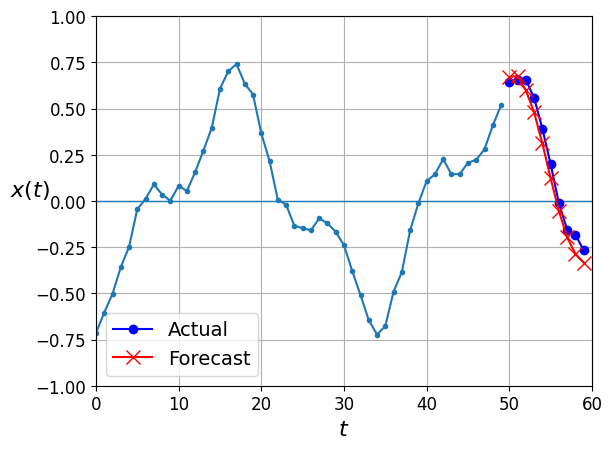

In [37]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

### Deep RNN with Batch Norm

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs=20,
                    validation_data = [X_valid,Y_valid])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - last_time_step_mse: 0.3368 - loss: 0.3368 - val_last_time_step_mse: 0.1038 - val_loss: 0.1065
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - last_time_step_mse: 0.0460 - loss: 0.0559 - val_last_time_step_mse: 0.0495 - val_loss: 0.0580
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - last_time_step_mse: 0.0386 - loss: 0.0485 - val_last_time_step_mse: 0.0379 - val_loss: 0.0481
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - last_time_step_mse: 0.0342 - loss: 0.0445 - val_last_time_step_mse: 0.0316 - val_loss: 0.0433
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - last_time_step_mse: 0.0307 - loss: 0.0414 - val_last_time_step_mse: 0.0279 - val_loss: 0.0399
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - last_time_step_mse: 0.0279 - loss: 0.0389 - val_last_time_step_mse: 0.0254 - val_loss: 0.0370
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - last_time_step_mse: 0.0257 - loss: 0.0371 - v

### Deep RNNs with layer Norm

In [39]:
from tensorflow.keras.layers import LayerNormalization

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        # Ensure the internal SimpleRNNCell is properly built
        self.simple_rnn_cell.build(input_shape)
        self.layer_norm.build((None, self.state_size))
        self.built = True

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        # Robust handling for both build and training phases
        if batch_size is None:
            if inputs is not None:
                batch_size = tf.shape(inputs)[0]
            else:
                batch_size = 1  # Fallback to 1 to avoid None errors

        if dtype is None:
            dtype = tf.float32  # Default dtype

        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [41]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs=20,
                    validation_data=[X_valid,Y_valid])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - last_time_step_mse: 0.2685 - loss: 0.2761 - val_last_time_step_mse: 0.0603 - val_loss: 0.0714
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - last_time_step_mse: 0.0550 - loss: 0.0653 - val_last_time_step_mse: 0.0438 - val_loss: 0.0536
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - last_time_step_mse: 0.0434 - loss: 0.0526 - val_last_time_step_mse: 0.0388 - val_loss: 0.0480
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - last_time_step_mse: 0.0387 - loss: 0.0474 - val_last_time_step_mse: 0.0353 - val_loss: 0.0443
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - last_time_step_mse: 0.0354 - loss: 0.0439 - val_last_time_step_mse: 0.0320 - val_loss: 0.0415
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - last_time_step_mse: 0.0323 - loss: 0.0413 - val_last_time_step_mse: 0.0288 - val_loss: 0.0390
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - last_time_step_mse: 0.0290 - loss: 0.0387 -

### Creating a Custom RNN Class

In [42]:
class MyRNN(keras.layers.Layer):
  def __init__(self,cell,return_sequences=False,**kwargs):
    super().__init__(**kwargs)
    self.cell = cell
    self.return_sequences = return_sequences
    self.get_initial_state = getattr(
        self.cell,"get_initial_state",self.fallback_initial_state
    )
  def fallback_initial_state(self,inputs):
    batch_size = tf.shape(inputs)[0]
    return [tf.zeros([batch_size,self.cell.state_size],dtype=inputs.dtype)]
  @tf.function
  def call(self,inputs):
    states = self.get_initial_state(inputs)
    shape = tf.shape(inputs)
    batch_size = shape[0]
    n_steps = shape[1]
    sequences = tf.TensorArray(
        inputs.dtype,size=(n_steps if self.return_sequences else 0)
    )
    outputs = tf.zeros(shape=[batch_size,self.cell.output_size],dtype=inputs.dtype)
    for step in tf.range(n_steps):
      outputs,states = self.cell(inputs[:,step],states)
      if self.return_sequences:
        sequences = sequences.write(step,outputs)
    if self.return_sequences:
      return tf.transpose(sequences.stack(),[1,0,2])
    else:
      return outputs

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

/tmp/ipython-input-307677171.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['sequential_9/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/kernel', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/recurrent_kernel', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/bias', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/layer_normalization_2/gamma', 'sequential_9/my_rnn/ln_simple_rnn_cell_2/layer_normalization_2/beta', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/simple_rnn_cell_3/kernel', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/simple_rnn_cell_3/recurrent_kernel', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/simple_rnn_cell_3/bias', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/layer_normalization_3/gamma', 'sequential_9/my_rnn_1/ln_simple_rnn_cell_3/layer_normalization_3/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - last_time_step_mse: 0.3839 - loss: 0.3842 - val_last_time_step_mse: 0.1558 - val_loss: 0.1508
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - last_time_step_mse: 0.1359 - loss: 0.1355 - val_last_time_step_mse: 0.1138 - val_loss: 0.1086
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - last_time_step_mse: 0.1065 - loss: 0.1040 - val_last_time_step_mse: 0.0998 - val_loss: 0.0944
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - last_time_step_mse: 0.0957 - loss: 0.0926 - val_last_time_step_mse: 0.0935 - val_loss: 0.0882
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - last_time_step_mse: 0.0907 - loss: 0.0874 - val_last_time_step_mse: 0.0902 - val_loss: 0.0851
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - last_time_step_mse: 0.0880 - loss: 0.0847 - val_last_time_step_mse: 0.0882 - val_loss: 0.0834
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - last_time_step_mse: 0.0865 - loss: 0.0833 - val_last_time_step

### LSTMs

In [44]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.LSTM(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs=20,
                    validation_data=[X_valid,Y_valid])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - last_time_step_mse: 0.0882 - loss: 0.0989 - val_last_time_step_mse: 0.0307 - val_loss: 0.0534
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - last_time_step_mse: 0.0277 - loss: 0.0501 - val_last_time_step_mse: 0.0195 - val_loss: 0.0423
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - last_time_step_mse: 0.0181 - loss: 0.0404 - val_last_time_step_mse: 0.0164 - val_loss: 0.0371
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - last_time_step_mse: 0.0147 - loss: 0.0357 - val_last_time_step_mse: 0.0145 - val_loss: 0.0341
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - last_time_step_mse: 0.0135 - loss: 0.0334 - val_last_time_step_mse: 0.0136 - val_loss: 0.0324
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - last_time_step_mse: 0.0128 - loss: 0.0318 - val_last_time_step_mse: 0.0130 - val_loss: 0.0311
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - last_time_step_mse: 0.0123 - loss: 0.0306 - 

In [45]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - last_time_step_mse: 0.0087 - loss: 0.0241


[0.02417117729783058, 0.008623134344816208]

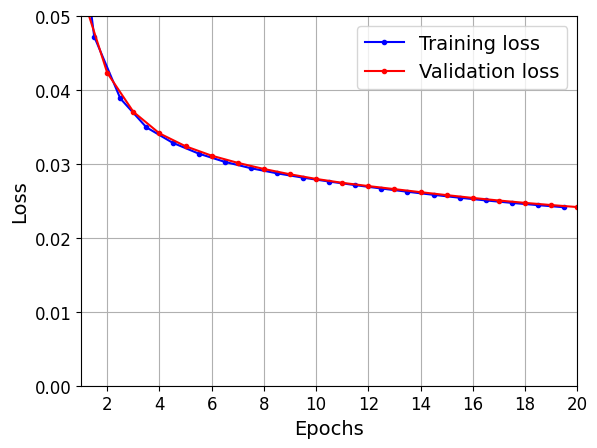

In [46]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [47]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


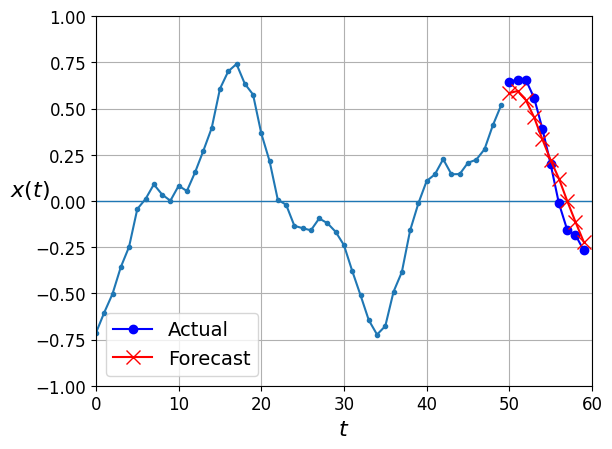

In [48]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### GRUs

In [49]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.GRU(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.GRU(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs=20,
                    validation_data=[X_valid,Y_valid])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - last_time_step_mse: 0.0878 - loss: 0.0941 - val_last_time_step_mse: 0.0441 - val_loss: 0.0554
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - last_time_step_mse: 0.0423 - loss: 0.0525 - val_last_time_step_mse: 0.0362 - val_loss: 0.0475
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - last_time_step_mse: 0.0358 - loss: 0.0457 - val_last_time_step_mse: 0.0320 - val_loss: 0.0437
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - last_time_step_mse: 0.0318 - loss: 0.0421 - val_last_time_step_mse: 0.0273 - val_loss: 0.0396
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - last_time_step_mse: 0.0283 - loss: 0.0389 - val_last_time_step_mse: 0.0241 - val_loss: 0.0363
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - last_time_step_mse: 0.0252 - loss: 0.0356 - val_last_time_step_mse: 0.0204 - val_loss: 0.0323
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - last_time_step_mse: 0.0205 - loss: 0.0320 - 

In [50]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - last_time_step_mse: 0.0092 - loss: 0.0230


[0.023066025227308273, 0.009185913018882275]

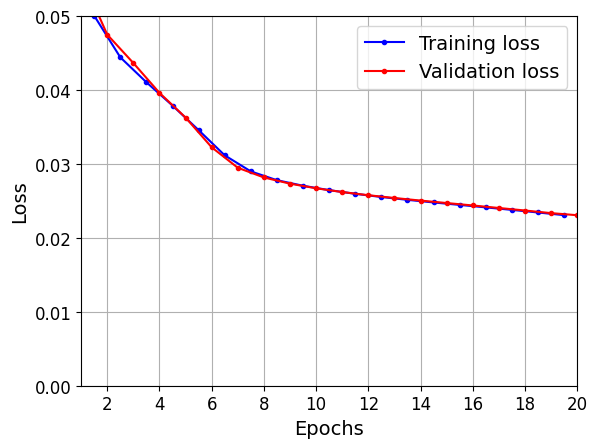

In [51]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [52]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


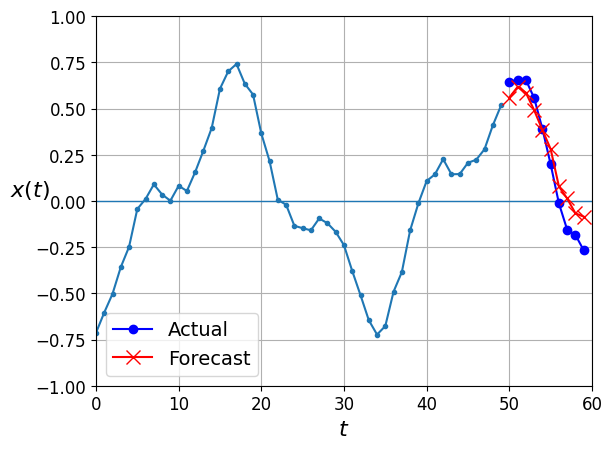

In [53]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Using One-Dimensional Convolutiional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - last_time_step_mse: 0.0886 - loss: 0.0944 - val_last_time_step_mse: 0.0373 - val_loss: 0.0462
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - last_time_step_mse: 0.0347 - loss: 0.0420 - val_last_time_step_mse: 0.0243 - val_loss: 0.0330
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - last_time_step_mse: 0.0240 - loss: 0.0317 - val_last_time_step_mse: 0.0176 - val_loss: 0.0281
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - last_time_step_mse: 0.0167 - loss: 0.0269 - val_last_time_step_mse: 0.0139 - val_loss: 0.0251
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - last_time_step_mse: 0.0137 - loss: 0.0247 - val_last_time_step_mse: 0.0125 - val_loss: 0.0237
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - last_time_step_mse: 0.0124 - loss: 0.0236 - val_last_time_step_mse: 0.0116 - val_loss: 0.0228
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - last_time_step_mse: 0.0116 - loss: 0.0228 - val_last_time

### Wavenet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```


In [55]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - last_time_step_mse: 0.0849 - loss: 0.0939 - val_last_time_step_mse: 0.0213 - val_loss: 0.0354
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0196 - loss: 0.0331 - val_last_time_step_mse: 0.0161 - val_loss: 0.0292
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - last_time_step_mse: 0.0152 - loss: 0.0284 - val_last_time_step_mse: 0.0139 - val_loss: 0.0265
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0135 - loss: 0.0263 - val_last_time_step_mse: 0.0128 - val_loss: 0.0251
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0125 - loss: 0.0251 - val_last_time_step_mse: 0.0120 - val_loss: 0.0242
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0119 - loss: 0.0243 - val_last_time_step_mse: 0.0116 - val_loss: 0.0235
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0115 - loss: 0.0237 - val_las

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [56]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [57]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [58]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [59]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - last_time_step_mse: 0.1342 - loss: 0.1382 - val_last_time_step_mse: 0.1199 - val_loss: 0.1229
Epoch 2/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - last_time_step_mse: 0.1177 - loss: 0.1224 - val_last_time_step_mse: 0.1186 - val_loss: 0.1215


### Exercises

In [60]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"

filepath = tf.keras.utils.get_file(
    FILENAME,
    DOWNLOAD_ROOT + FILENAME,
    cache_subdir="datasets/quickdraw",
    extract = True
)
quickdraw_dir = Path(filepath)

with open(quickdraw_dir / "eval.tfrecord.classes") as f:
  class_names = [c.strip() for c in f.readlines()]
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)
N_SAMPLES_PER_CLASS = 2000
N_CLASSES = len(class_names)
N_TRAIN = N_SAMPLES_PER_CLASS * N_CLASSES

N_VALID = int(0.1 * N_TRAIN)
N_TEST = int(0.1 * N_TRAIN)

def parse(data_batch):
  feature_descriptions = {
      "ink":tf.io.VarLenFeature(dtype=tf.float32),
      "shape":tf.io.FixedLenFeature([2],dtype=tf.int64),
      "class_index":tf.io.FixedLenFeature([1],dtype=tf.int64)
  }
  examples = tf.io.parse_example(data_batch,feature_descriptions)

  flat_sketches = tf.sparse.to_dense(examples["ink"])

  sketches = tf.reshape(flat_sketches,shape=[tf.size(data_batch),-1,3])

  lengths = examples["shape"][:,0]

  labels = examples["class_index"][:,0]

  return sketches,lengths, labels

def quickdraw_vector_dataset(filepaths,repeat=True,shuffle=60000,batch_size=32):
  dataset = tf.data.Dataset.from_tensor_slices(filepaths)
  dataset = dataset.shuffle(len(filepaths)).interleave(
      tf.data.TFRecordDataset,
      cycle_length=4,
      num_parallel_calls=tf.data.AUTOTUNE
  )

  if repeat:
    dataset = dataset.repeat()
  if shuffle:
    dataset = dataset.shuffle(shuffle)
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(
      parse,
      num_parallel_calls=tf.data.AUTOTUNE
  )
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset


1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


In [66]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [67]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [68]:
train_set = quickdraw_dataset(train_files,shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [69]:
for sketches,lengths,labels in train_set.take(1):
  print("sketches =", sketches)
  print("lengths =", lengths)
  print("labels =", labels)

sketches = tf.Tensor(
[[[-0.16867469  0.30980393  0.        ]
  [-0.01807229  0.13333333  0.        ]
  [ 0.05421687  0.11372551  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.03187251 -0.01176471  0.        ]
  [-0.03187251 -0.03137255  0.        ]
  [-0.1434263  -0.01960784  0.        ]
  ...
  [ 0.02788845  0.03921568  0.        ]
  [ 0.06374502 -0.01176471  0.        ]
  [ 0.12350598 -0.05882353  1.        ]]

 [[-0.27559057  0.          0.        ]
  [-0.06692913  0.01244813  0.        ]
  [-0.21653543  0.20746888  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.3098039   0.          0.        ]
  [ 0.54509807 -0.03212851  0.        ]
  [ 0.          0.02409638  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

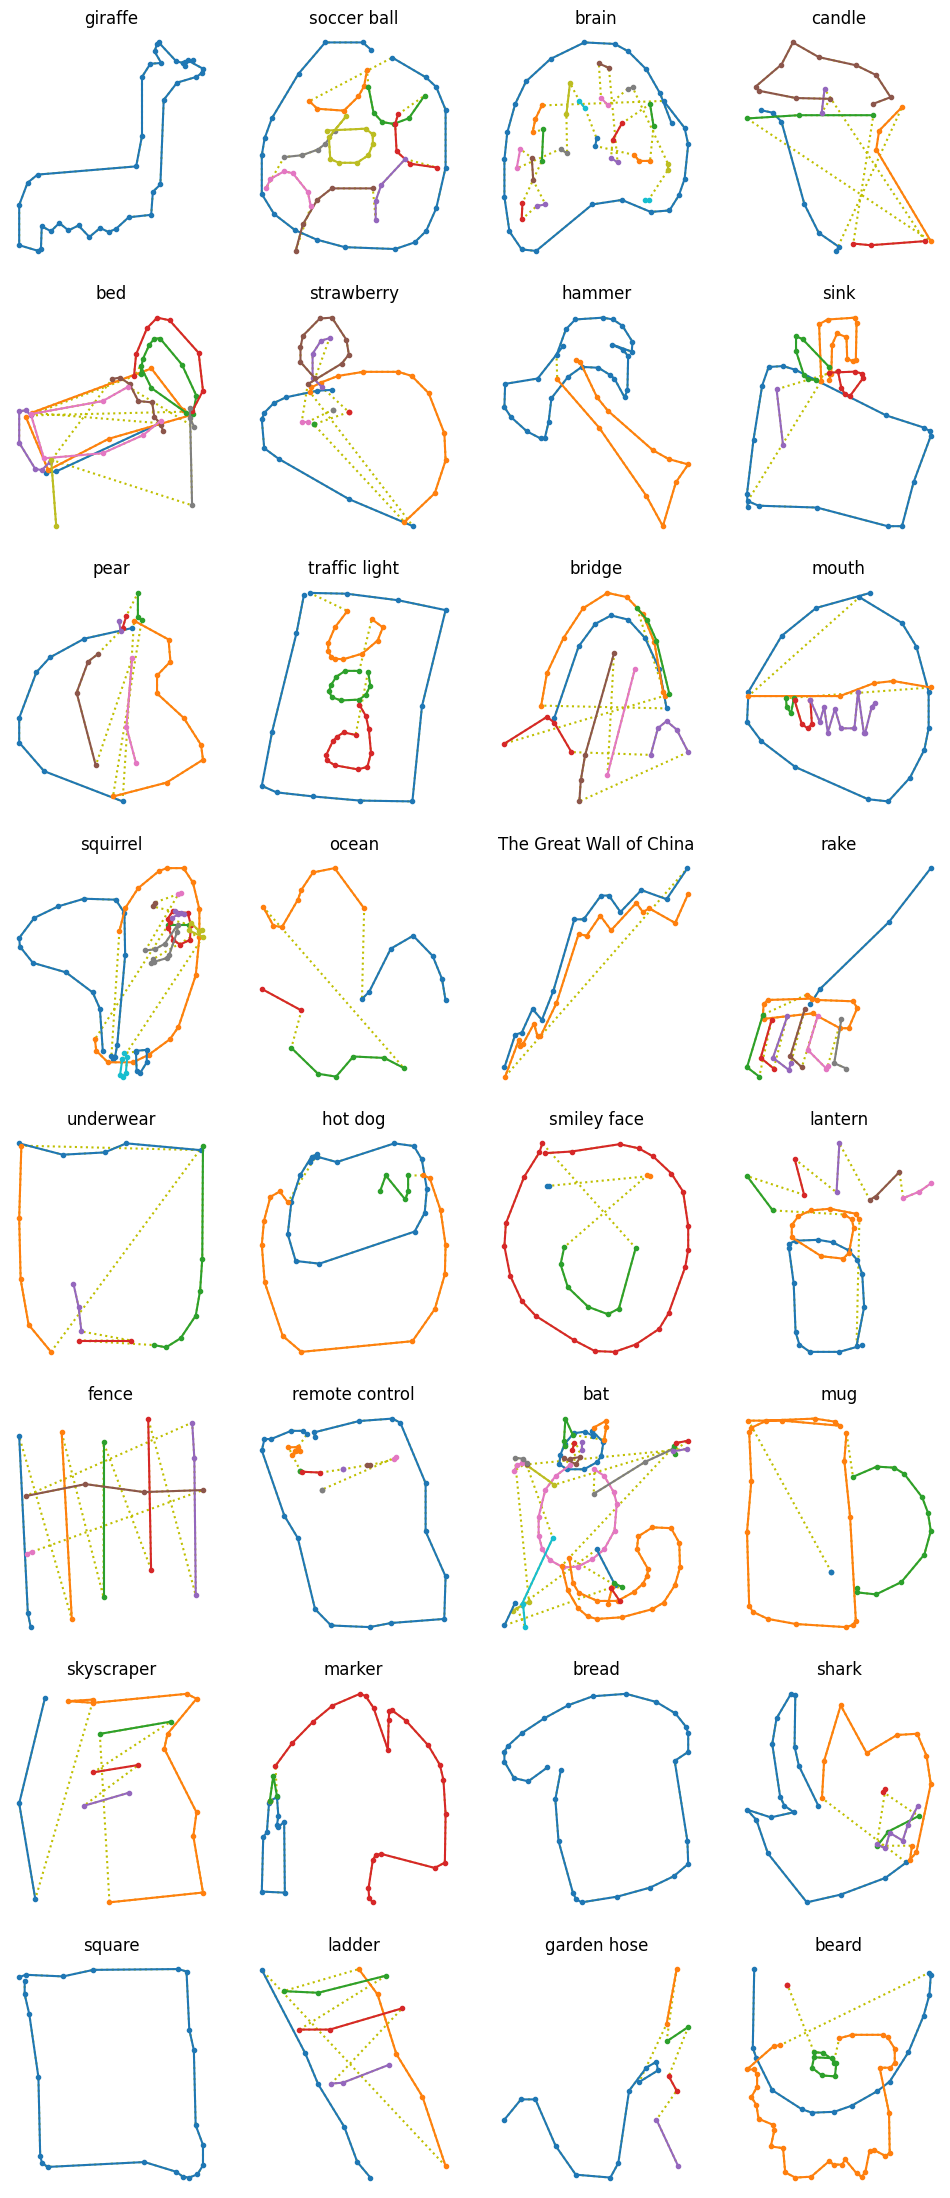

In [73]:
def draw_sketch(sketch,label=None):
  origin = np.array([[0.,0.,0.]])
  sketch = np.r_[origin,sketch]
  stroke_end_indices = np.argwhere(sketch[:,-1]==1.)[:,0]
  coordinates = np.cumsum(sketch[:,:2],axis=0)
  strokes = np.split(coordinates,stroke_end_indices+1)
  title = class_names[label.numpy()] if label is not None else "Try to guess"
  plt.title(title)
  plt.plot(coordinates[:, 0],-coordinates[:,1],"y:")
  for stroke in strokes:
    plt.plot(stroke[:, 0],-stroke[:, 1],".-")
  plt.axis("off")


def draw_sketches(sketches,lengths,labels):
  n_sketches = len(sketches)
  n_cols = 4
  n_rows = (n_sketches - 1) // n_cols + 1
  plt.figure(figsize=[n_cols *3,n_rows *3.5])
  for index,sketch,length,label in zip(range(n_sketches),sketches,lengths,labels):
    plt.subplot(n_rows,n_cols,index+1)
    draw_sketch(sketch[:length],label)
  plt.show()
for sketches,lengths,labels in train_set.take(1):
  draw_sketches(sketches,lengths,labels)


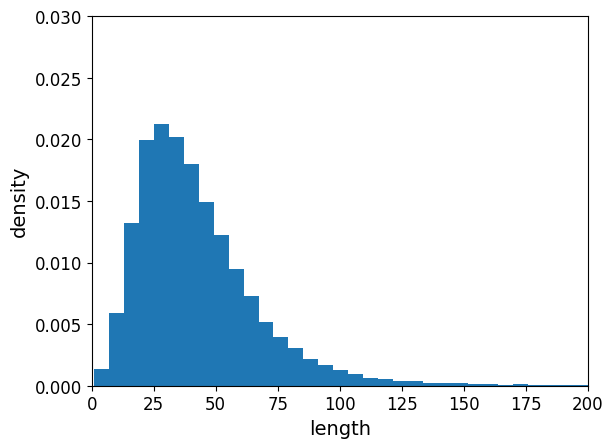

In [77]:
lengths = np.concatenate([lengths for _, lenghts, _ in train_set.take(1000)])
plt.hist(lengths,bins=150,density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [78]:
def crop_long_sketches(dataset,max_length=100):
  return dataset.map(lambda inks,lengths,labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32,kernel_size=5,strides=2,activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2,clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=1,
                    validation_data=cropped_valid_set)

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn")